In [292]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score
)
from xgboost import XGBRegressor

In [293]:
# csv 로드
df = pd.read_csv("labels_repair_cost_12_clean.csv")
# 필요한 컬럼만 추출
df = df[['repair', 'car_type', 'total_cost', 'accident_id']] # accident_id는 이상치 추적용

print("원본 행 수:", len(df))

before = len(df)

# total_cost 결측치 및 0원/음수 제거
df = df[df["total_cost"].notna()]
df = df[df["total_cost"] > 0]

after = len(df)

print(f"총계 0원/이상치 제거: {before - after}개 제거됨")
print("제거 후 행 수:", after)

원본 행 수: 50024
총계 0원/이상치 제거: 1개 제거됨
제거 후 행 수: 50023


In [294]:
# 유사 파트 통합
PART_CANONICAL = {
    "Front bumper": "Front bumper",
    "Rear bumper": "Rear bumper",
     
    "Head lights(L)": "Head lights",
    "Head lights(R)": "Head lights",
    "Head lights": "Head lights",
    
    "Bonnet": "Bonnet",
    "Windshield": "Windshield",
    "Roof": "Roof",
    "Trunk lid": "Trunk lid",
    
    "Rear lamp(L)": "Rear lamp",
    "Rear lamp(R)": "Rear lamp",
    "Rear lamp": "Rear lamp",

    "Front fender(L)": "Front fender",
    "Front fender(R)": "Front fender",
    "Front fender": "Front fender",

    "Side mirror(L)": "Side mirror",
    "Side mirror(R)": "Side mirror",
    "Side mirror": "Side mirror",

    "Front door(L)": "Front door",
    "Front door(R)": "Front door",
    "Front door": "Front door",

    "Rear door(L)": "Rear door",
    "Rear door(R)": "Rear door",
    "Rear door": "Rear door",

    "Rocker panel(L)": "Rocker panel",
    "Rocker panel(R)": "Rocker panel",
    "Rocker panel": "Rocker panel",

    "A pillar(L)": "A pillar",
    "A pillar(R)": "A pillar",
    "A pillar": "A pillar",

    "B pillar(L)": "B pillar",
    "B pillar(R)": "B pillar",
    "B pillar": "B pillar",

    "C pillar(L)": "C pillar",
    "C pillar(R)": "C pillar",
    "C pillar": "C pillar",

    "Rear fender(L)": "Rear fender",
    "Rear fender(R)": "Rear fender",
    "Rear fender": "Rear fender",

    "Front Wheel(L)": "Front Wheel",
    "Front Wheel(R)": "Front Wheel",
    "Front Wheel": "Front Wheel",
    "Rear Wheel(L)": "Rear Wheel",
    "Rear Wheel(R)": "Rear Wheel",
    "Rear Wheel": "Rear Wheel",

    "Rear windshield": "Rear windshield",
    "Undercarriage": "Undercarriage",
}

def canonicalize_part(part):
    return PART_CANONICAL.get(part, part)

In [295]:
# repair 문자열 파싱
def parse_repair(repair_str):
    if pd.isna(repair_str):
        return [], [], []

    parts = []
    works_total = []
    partwork_pairs = []

    for seg in repair_str.split("|"):
        if ":" not in seg:
            continue

        raw_part, work_str = seg.split(":", 1)
        part = canonicalize_part(raw_part)
        works = work_str.split(",")

        parts.append(part)
        works_total.extend(works)

        for w in works:
            partwork_pairs.append(f"{part}_{w}")

    return parts, works_total, partwork_pairs

df["parts"], df["works"], df["partwork"] = zip(*df["repair"].apply(parse_repair))

print("\n=== 파싱 결과 샘플 ===")
print(df[["repair", "parts", "works", "partwork"]].head())


=== 파싱 결과 샘플 ===
                                              repair  \
0             Rear bumper:coating,repair,sheet_metal   
1  Front fender(R):coating,sheet_metal|Front door...   
2  Head lights:repair|Front fender(L):sheet_metal...   
3  Rear Wheel(R):repair|Rear fender(R):coating,sh...   
4  Head lights:exchange|Front fender(R):exchange|...   

                                               parts  \
0                                      [Rear bumper]   
1  [Front fender, Front door, Front bumper, Bonne...   
2          [Head lights, Front fender, Front bumper]   
3  [Rear Wheel, Rear fender, Rear door, Rear bumper]   
4  [Head lights, Front fender, Front door, Front ...   

                                               works  \
0                     [coating, repair, sheet_metal]   
1  [coating, sheet_metal, coating, sheet_metal, c...   
2    [repair, sheet_metal, coating, repair, coating]   
3  [repair, coating, sheet_metal, coating, sheet_...   
4  [exchange, exchange, shee

In [296]:
# 수치 피처 생성
df["num_parts"] = df["parts"].apply(len)
df["num_works"] = df["works"].apply(len)
df["num_sheet_metal"] = df["works"].apply(lambda x: x.count("sheet_metal"))
df["num_exchange"] = df["works"].apply(lambda x: x.count("exchange"))
df["num_repair"] = df["works"].apply(lambda x: x.count("repair"))

numeric_cols = [
    "num_parts", "num_works", "num_sheet_metal",
    "num_exchange", "num_repair"
]

X_num = df[numeric_cols].values

In [297]:
# 멀티핫 인코딩
mlb_pw = MultiLabelBinarizer()
X_partwork = mlb_pw.fit_transform(df["partwork"])

mlb_p = MultiLabelBinarizer()
X_parts = mlb_p.fit_transform(df["parts"])

mlb_w = MultiLabelBinarizer()
X_works = mlb_w.fit_transform(df["works"])

print("partwork feature 수:", X_partwork.shape[1])
print("parts feature 수:", X_parts.shape[1])
print("works feature 수:", X_works.shape[1])

# 차종 원핫 인코딩
car_ohe = pd.get_dummies(df["car_type"], prefix="car").values

partwork feature 수: 78
parts feature 수: 20
works feature 수: 4


In [298]:
# 최종 X, y 생성
X = np.hstack([
    X_partwork,
    X_parts,
    # X_works,
    X_num,
    car_ohe
])

y = np.log1p(df["total_cost"])

print("최종 X shape:", X.shape)

최종 X shape: (50023, 143)


In [299]:
# 트레이닝 / Validation / 테스트 셋 분할
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=1
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=2
)

print("Train set 크기:", X_train.shape[0])
print("Validation set 크기:", X_val.shape[0])
print("Test set 크기:", X_test.shape[0])

Train set 크기: 35016
Validation set 크기: 7503
Test set 크기: 7504


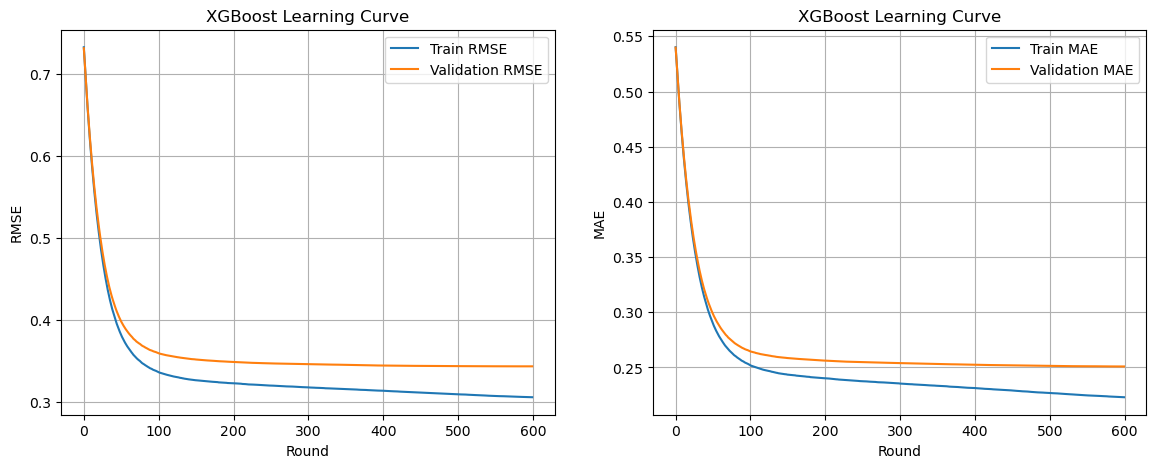

In [300]:
# XGBoost모델 구성 및 트레이닝
model = XGBRegressor(
    n_estimators=600,
    max_depth=9,
    learning_rate=0.03,
    subsample=0.8,
    colsample_bytree=0.75,
    tree_method="hist",
    n_jobs=-1,
    random_state=1,
    eval_metric=["rmse", "mae"]
)

model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=False
)

# 러닝 커브 시각화 (RMSE, MAE)
import matplotlib.pyplot as plt

results = model.evals_result()

train_rmse = results['validation_0']['rmse']
val_rmse   = results['validation_1']['rmse']
train_mae = results['validation_0']['mae']
val_mae   = results['validation_1']['mae']

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(train_rmse, label="Train RMSE")
plt.plot(val_rmse, label="Validation RMSE")
plt.xlabel("Round")
plt.ylabel("RMSE")
plt.title("XGBoost Learning Curve")
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_mae, label="Train MAE")
plt.plot(val_mae, label="Validation MAE")
plt.xlabel("Round")
plt.ylabel("MAE")
plt.title("XGBoost Learning Curve")
plt.grid()
plt.legend()

plt.show()


=== Test 평가 결과 ===
RMSE: 357780.4159640705
MAE : 179721.72173564724
R²  : 0.7501348274115721
Accuracy (±10%): 27.13%
Accuracy (±20%): 50.81%
Accuracy (±30%): 68.36%
Accuracy (±40%): 80.26%
Accuracy (±50%): 88.01%


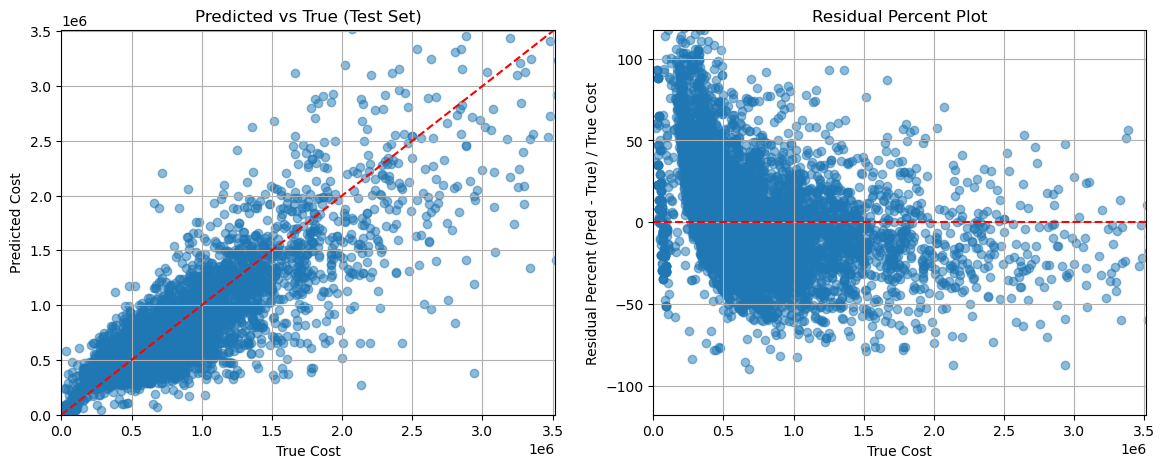

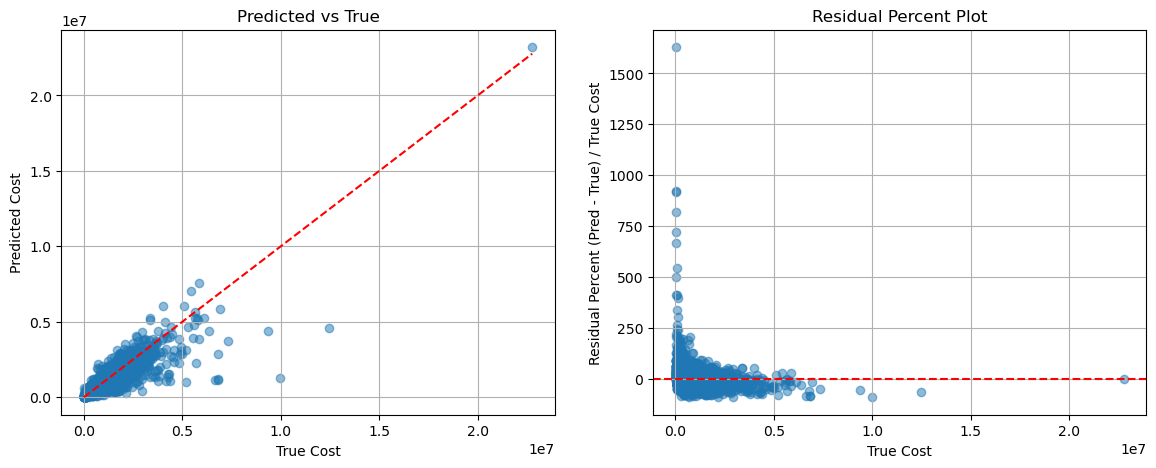

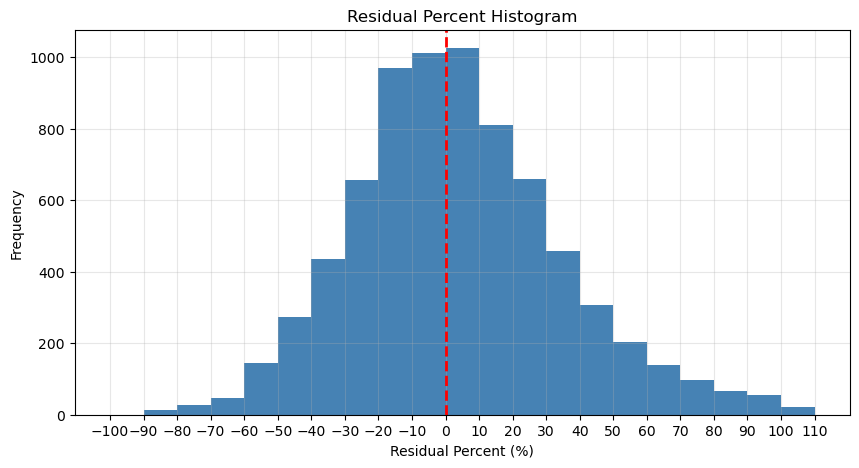


=== 실제 vs 예측 (샘플 50개) ===
       true_cost  pred_cost accident_id
26713    2002920    1578773  as-0052653
35536     454657     574071  as-0069158
30590     467038     524127  as-0059636
43565     714270     358421  as-0082924
6309      803078     866863  as-0013979
26927    2201992    1703300  as-0053021
41939    2170800    1763898  as-0080365
23088     712368     592236  as-0046124
46123      68700      64869  as-0088476
25774     264018     282759  as-0050769
40019    1537879    1722949  as-0077334
41921     682315     445582  as-0080335
4943      722548     654171  as-0010517
2292      587097     513773  as-0004678
13153    1733718     817042  as-0028203
24745     328519     654749  as-0048986
27130     529057     382980  as-0053464
43549     556256     547009  as-0082892
16633     707068     590570  as-0034186
26751    2632959    3243016  as-0052728
35834     858738     749475  as-0069683
26879    1875020    2351348  as-0052945
2509      322836     357916  as-0005056
37264     880

In [304]:
# 테스트
pred_log = model.predict(X_test)
pred_cost = np.expm1(pred_log)
true_cost = np.expm1(y_test)

rmse = np.sqrt(mean_squared_error(true_cost, pred_cost))
mae = mean_absolute_error(true_cost, pred_cost)
r2 = r2_score(true_cost, pred_cost)
acc10 = np.mean(np.abs(pred_cost - true_cost) / true_cost < 0.10)
acc20 = np.mean(np.abs(pred_cost - true_cost) / true_cost < 0.20)
acc30 = np.mean(np.abs(pred_cost - true_cost) / true_cost < 0.30)
acc40 = np.mean(np.abs(pred_cost - true_cost) / true_cost < 0.40)
acc50 = np.mean(np.abs(pred_cost - true_cost) / true_cost < 0.50)

print("\n=== Test 평가 결과 ===")
print("RMSE:", rmse)
print("MAE :", mae)
print("R²  :", r2)
print(f"Accuracy (±10%): {acc10*100:.2f}%")
print(f"Accuracy (±20%): {acc20*100:.2f}%")
print(f"Accuracy (±30%): {acc30*100:.2f}%")
print(f"Accuracy (±40%): {acc40*100:.2f}%")
print(f"Accuracy (±50%): {acc50*100:.2f}%")

# 테스트 결과 시각화
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.scatter(true_cost, pred_cost, alpha=0.5)
plt.plot([0,max(true_cost)],[0,max(true_cost)],"r--")
limit = np.percentile(true_cost, 99)
plt.xlim(0, limit)
plt.ylim(0, limit)
plt.xlabel("True Cost")
plt.ylabel("Predicted Cost")
plt.title("Predicted vs True (Test Set)")
plt.grid()

residual_percent = ((pred_cost - true_cost) / true_cost) * 100

plt.subplot(1, 2, 2)
plt.scatter(true_cost, residual_percent, alpha=0.5)
limit = np.percentile(true_cost, 99)
limit_y = np.percentile(np.abs(residual_percent), 99)
plt.xlim(0, limit)
plt.ylim(-limit_y, limit_y)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("True Cost")
plt.ylabel("Residual Percent (Pred - True) / True Cost")
plt.title("Residual Percent Plot")
plt.grid()

plt.show()

# 이상치 제거x 버전
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.scatter(true_cost, pred_cost, alpha=0.5)
plt.plot([0,max(true_cost)],[0,max(true_cost)],"r--")
plt.xlabel("True Cost")
plt.ylabel("Predicted Cost")
plt.title("Predicted vs True")
plt.grid()

plt.subplot(1, 2, 2)
plt.scatter(true_cost, residual_percent, alpha=0.5)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("True Cost")
plt.ylabel("Residual Percent (Pred - True) / True Cost")
plt.title("Residual Percent Plot")
plt.grid()

plt.show()

plt.figure(figsize=(10, 5))
plt.hist(residual_percent, bins=np.arange(-100, 120, 10), color='steelblue', alpha=1)
plt.xticks(np.arange(-100, 120, 10))
plt.axvline(0, color='red', linestyle='--', linewidth=2)
plt.xlabel("Residual Percent (%)")
plt.ylabel("Frequency")
plt.title("Residual Percent Histogram")
plt.grid(True, alpha=0.3)
plt.show()


# 실제 vs 예측 예시
sample = pd.DataFrame({
    "true_cost": true_cost.astype(int),
    "pred_cost": pred_cost.astype(int),
    "accident_id": df.loc[y_test.index, "accident_id"]
}).head(50)

print("\n=== 실제 vs 예측 (샘플 50개) ===")
print(sample)

In [302]:
# 모델 저장
model.save_model("repair_cost_model.json")